In [1]:
!pip install requests mlflow tensorflow matplotlib bing-image-downloader


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import os
import requests

import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr

In [28]:
image_path = "./data/cat_dogs/"

In [34]:
def download_images(query, limit, output_dir):
    downloader.download(query,
                         limit=limit,
                         output_dir=output_dir,
                         adult_filter_off=True,
                         force_replace=False,
                         timeout=60)

download_images("cat", 100, image_path)
download_images("dog", 100, image_path)

[%] Downloading Images to C:\Users\aplle\OneDrive\Documentos\2024-2\ArquitecturaDeSoftware\ml-flow-env\notebook\data\cat_dogs\cat


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://static.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://get.pxhere.com/photo/animal-pet-kitten-cat-small-mammal-fauna-heal-blue-eye-close-up-nose-whiskers-vertebrate-domestic-lying-tabby-cat-norwegian-forest-cat-ginger-fur-small-to-medium-sized-cats-cat-like-mammal-carnivoran-domestic-short-haired-cat-domestic-long-haired-cat-609263.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://upload.wikimedia.org/wikipedia/commons/c/c7/Domestic_shorthaired_cat_face.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://get.pxhere.com

KeyboardInterrupt: 

In [29]:
for category in ["cat","dog"]:
    data_dir = os.path.join(image_path, category)
    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [30]:
learning_rate = 0.01
num_epochs = 50
batch_size = 32
input_shape = (224, 224, 3)

In [31]:
experiment_name = "cat-dog-classifier-mobilenet"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

In [32]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 202 files belonging to 2 classes.
Using 162 files for training.


In [33]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 202 files belonging to 2 classes.
Using 40 files for validation.


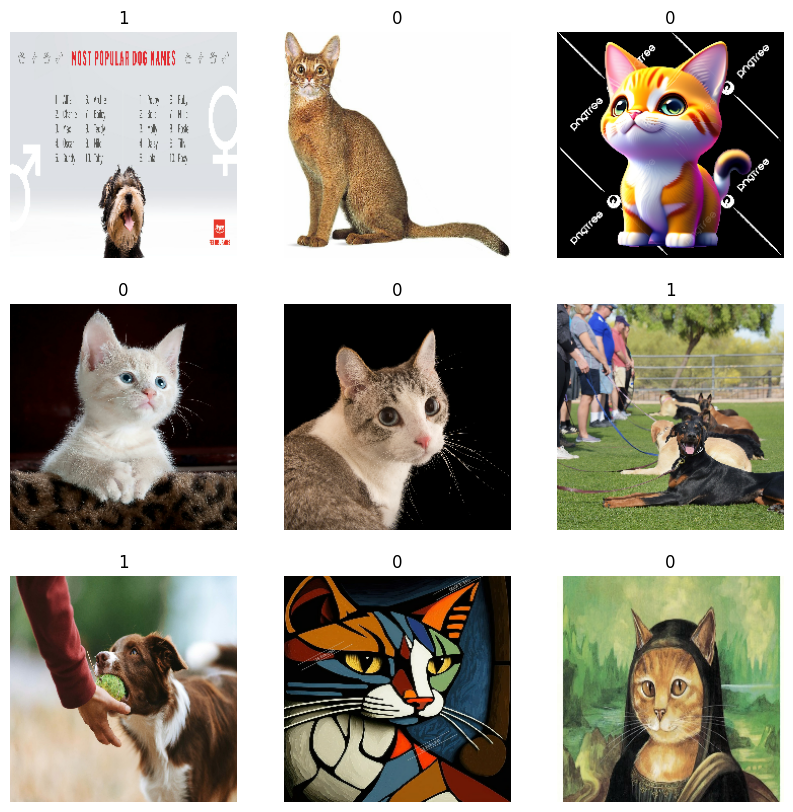

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

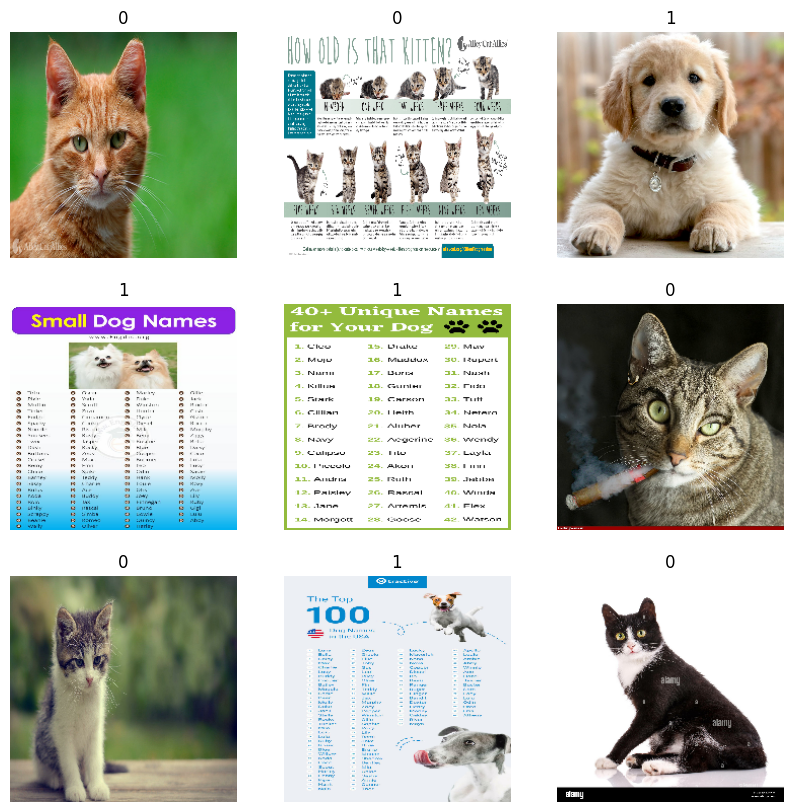

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [36]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

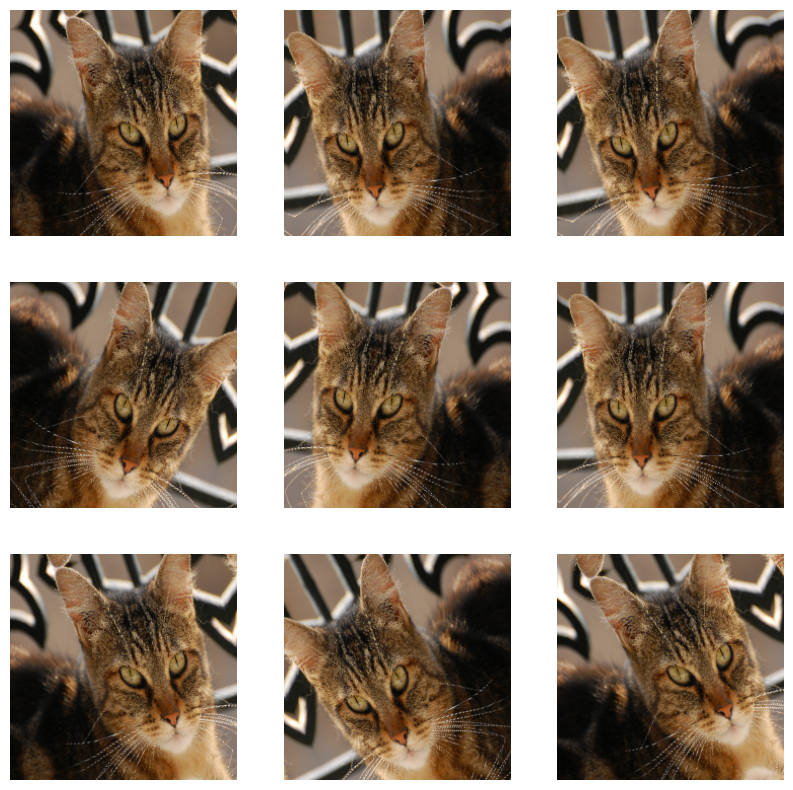

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [38]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [39]:
base_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

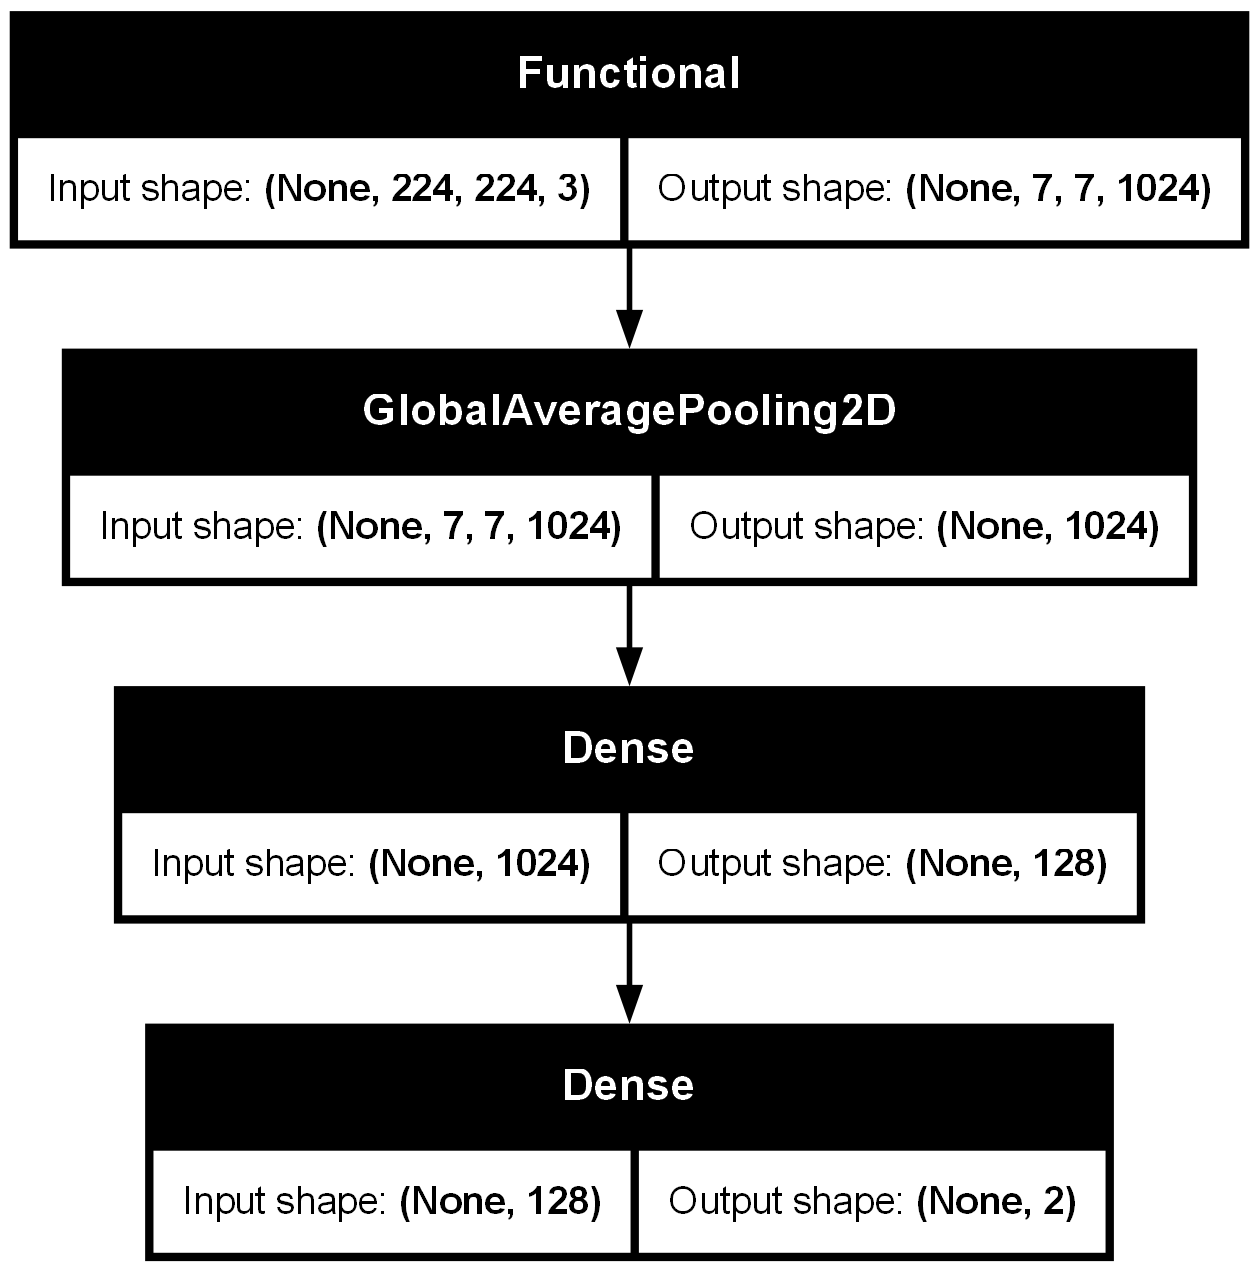

In [40]:
keras.utils.plot_model(model, show_shapes=True)

In [41]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [42]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [43]:
history = model.fit(
    augmented_train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/50
6/6 - 11s - 2s/step - accuracy: 0.5494 - loss: 6.1172 - val_accuracy: 0.5000 - val_loss: 2.9190
Epoch 2/50
6/6 - 6s - 1s/step - accuracy: 0.5864 - loss: 1.2962 - val_accuracy: 0.5000 - val_loss: 1.9213
Epoch 3/50
6/6 - 6s - 1s/step - accuracy: 0.5988 - loss: 1.0425 - val_accuracy: 0.5750 - val_loss: 1.0431
Epoch 4/50
6/6 - 6s - 1s/step - accuracy: 0.6111 - loss: 0.8568 - val_accuracy: 0.5250 - val_loss: 1.0141
Epoch 5/50
6/6 - 6s - 1s/step - accuracy: 0.6605 - loss: 0.5803 - val_accuracy: 0.6250 - val_loss: 0.8068
Epoch 6/50
6/6 - 6s - 1s/step - accuracy: 0.5679 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.8474
Epoch 7/50
6/6 - 7s - 1s/step - accuracy: 0.6235 - loss: 0.6025 - val_accuracy: 0.6250 - val_loss: 0.7191
Epoch 8/50
6/6 - 6s - 1s/step - accuracy: 0.7284 - loss: 0.5476 - val_accuracy: 0.6250 - val_loss: 0.7361
Epoch 9/50
6/6 - 6s - 999ms/step - accuracy: 0.6481 - loss: 0.5536 - val_accuracy: 0.6750 - val_loss: 0.7406
Epoch 10/50
6/6 - 6s - 1s/step - accuracy:

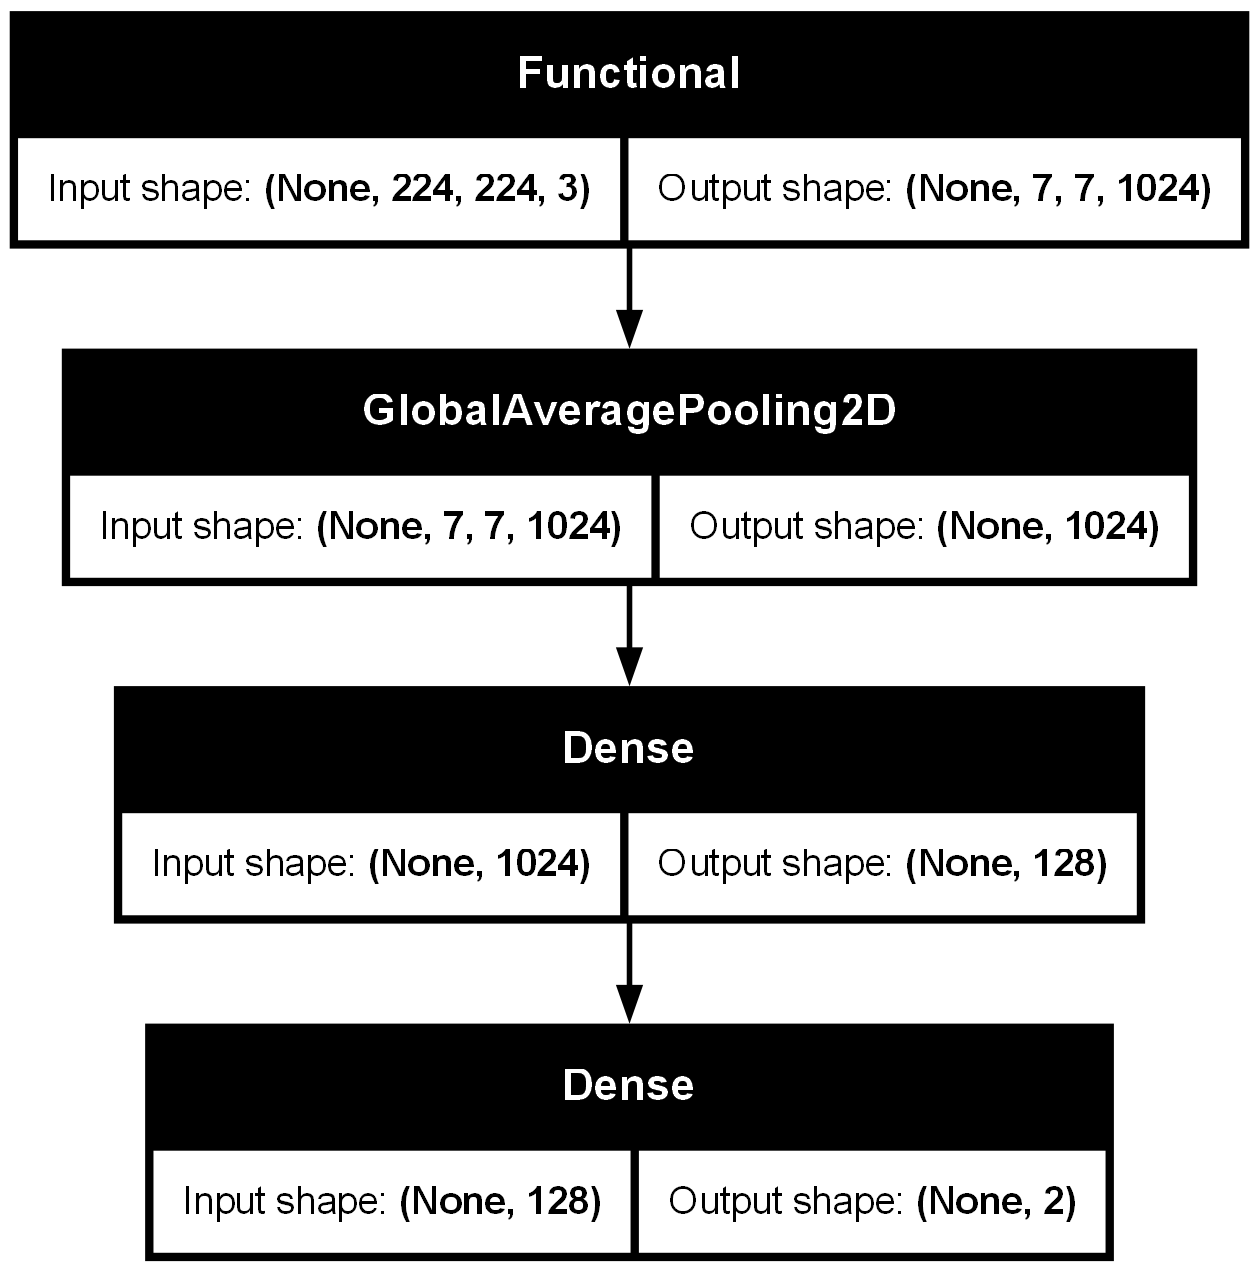

In [82]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

In [96]:
mlflow.set_tracking_uri(r"file:///C:/Users/aplle/OneDrive/Documentos/2024-2/ArquitecturaDeSoftware/ml-flow-env/notebook/mlruns")

In [86]:
experiment_name = "my_experiment"
run_name = "run_01"


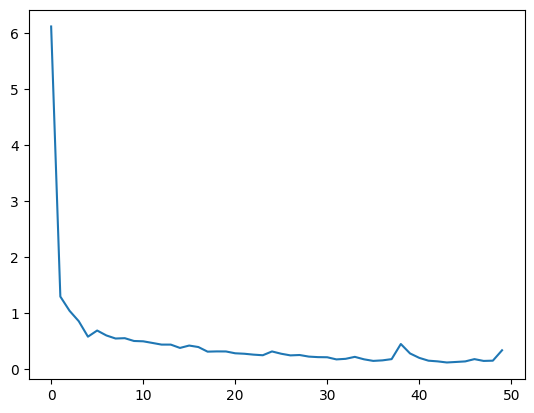

In [87]:
import matplotlib.pyplot as plt

# Guardar una imagen del modelo o de cualquier cosa que quieras
plt.plot(history.history['loss'])
plt.savefig('model.png')  # Guarda la imagen en el directorio actual

mlflow.log_artifact('model.png', 'model_plot')


In [93]:
experiment_name = "model"
run_name = "run_02"

In [94]:
mlflow.end_run()

2024/11/09 17:19:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/09 17:19:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run ID: df01e6bc84ba43dd9b1e6cce3e23d8aa


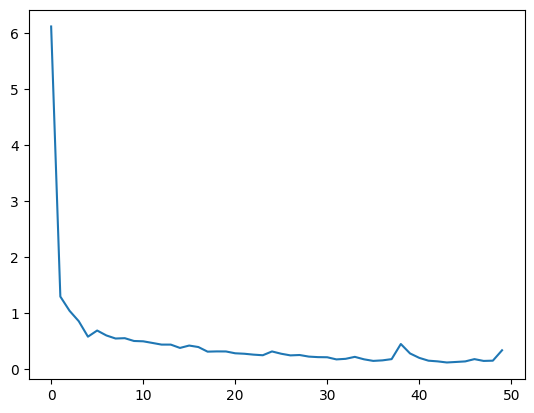

In [97]:
with mlflow.start_run(run_name=run_name) as mlflow_run:

    # Establece tags
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    # Log del modelo
    mlflow.keras.log_model(model, "model")

    # Log de parámetros
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("num_epochs", 5)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("input_shape", "(784,)")

    # Log de métricas
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    # Guardar un gráfico como artefacto
    plt.plot(history.history['loss'])
    plt.savefig('model.png')  # Guarda la imagen en el directorio actual
    mlflow.log_artifact('model.png', 'model_plot')

    # Imprime el Run ID
    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID:", mlflow_run_id)


In [99]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")


In [92]:
mlflow.create_experiment(experiment_name)

'196408134553895985'

In [103]:

# Paso 1: Configuración de MLflow (si usas un servidor remoto, descomenta y configura la URL)
# mlflow.set_tracking_uri("http://<URL_DEL_SERVIDOR_MLFLOW>")  # Descomenta si usas un servidor remoto

# Paso 2: Crear un experimento
experiment_name = "my_experiment"

# Verificar si el experimento ya existe
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    # Crear el experimento si no existe
    print(f"Creando un nuevo experimento con el nombre '{experiment_name}'.")
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id
    print(f"El experimento '{experiment_name}' ya existe con ID: {experiment_id}")

# Establecer el experimento activo
mlflow.set_experiment(experiment_name)

# Paso 3: Iniciar un "run" y registrar parámetros, métricas y modelos
run_name = "run_1"

Creando un nuevo experimento con el nombre 'my_experiment'.


2024/11/09 17:24:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/09 17:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/09 17:24:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_1 at: http://127.0.0.1:5000/#/experiments/412419221304818620/runs/3b17533c20d744c88f1df353c84d56af.
2024/11/09 17:24:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/412419221304818620.


MLFlow Run ID: 3b17533c20d744c88f1df353c84d56af


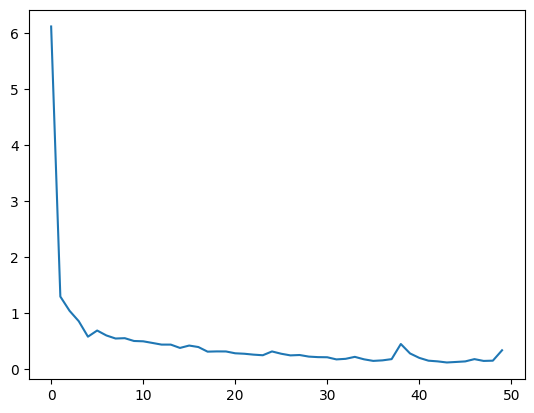

In [104]:
with mlflow.start_run(run_name=run_name) as mlflow_run:

    # Establece tags
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    # Log del modelo
    mlflow.keras.log_model(model, "model")

    # Log de parámetros
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("num_epochs", 5)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("input_shape", "(784,)")

    # Log de métricas
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    # Guardar un gráfico como artefacto
    plt.plot(history.history['loss'])
    plt.savefig('model.png')  # Guarda la imagen en el directorio actual
    mlflow.log_artifact('model.png', 'model_plot')

    # Imprime el Run ID
    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID:", mlflow_run_id)


In [101]:
experiment_name = "my_experiment"

# Obtener todos los experimentos disponibles
experiment = mlflow.get_experiment_by_name(experiment_name)


In [102]:
print(experiment)

None


In [100]:
with mlflow.start_run(run_name=run_name) as mlflow_run:

    # Establece tags
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    # Log del modelo
    mlflow.keras.log_model(model, "model")

    # Log de parámetros
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("num_epochs", 5)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("input_shape", "(784,)")

    # Log de métricas
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    # Guardar un gráfico como artefacto
    plt.plot(history.history['loss'])
    plt.savefig('model.png')  # Guarda la imagen en el directorio actual
    mlflow.log_artifact('model.png', 'model_plot')

    # Imprime el Run ID
    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID:", mlflow_run_id)


RestException: RESOURCE_DOES_NOT_EXIST: Could not find experiment with ID 719178500928804081

In [68]:
experiment = mlflow.get_experiment_by_name(experiment_name)

# Verificar si se encontró el experimento
if experiment:
    print(f"Experimento encontrado: {experiment}")
else:
    print(f"El experimento {experiment_name} no existe.")

Experimento encontrado: <Experiment: artifact_location='file:///C:/Users/aplle/OneDrive/Documentos/2024-2/ArquitecturaDeSoftware/ml-flow-env/notebook/mlruns/719178500928804081', creation_time=1731189765394, experiment_id='719178500928804081', last_update_time=1731189765394, lifecycle_stage='active', name='my_experiment', tags={'base_model': 'MobileNet'}>


In [69]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [114]:
%reload_ext tensorboard

In [115]:
%load_ext tensorboard
%tensorboard --logdir logs/cat-dog-classifier-mobilenet

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6616), started 1:45:03 ago. (Use '!kill 6616' to kill it.)

In [116]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "cat/Image_17.jpg"), target_size=input_shape
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
This image is 95.78% cat and 4.22% dog.


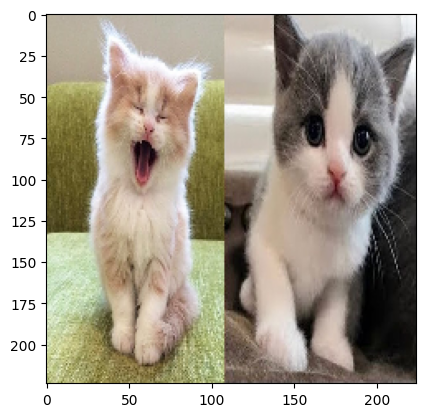

In [117]:
predictions = model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

In [118]:
# Logged model in MLFlow
logged_model_path = f"runs:/{mlflow_run_id}/model"

# Load model as a Keras model
loaded_model = mlflow.keras.load_model(logged_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 95.78% cat and 4.22% dog.


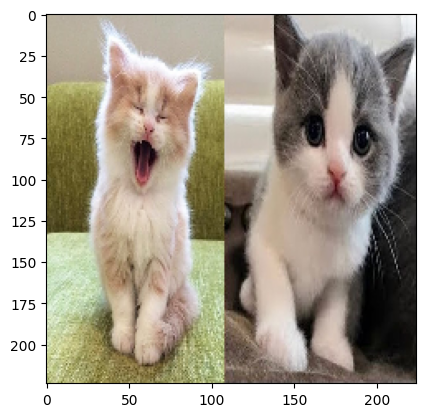

In [119]:
predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

In [120]:
model_name = "cat_dog_classifier"
model_version = 1

In [121]:
print("MLFlow Run ID: ", mlflow_run_id)

MLFlow Run ID:  3b17533c20d744c88f1df353c84d56af


In [122]:
with mlflow.start_run(run_id=mlflow_run_id) as run:
    result = mlflow.register_model(
        logged_model_path,
        model_name
    )

Successfully registered model 'cat_dog_classifier'.
2024/11/09 17:39:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: cat_dog_classifier, version 1
Created version '1' of model 'cat_dog_classifier'.
2024/11/09 17:39:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_1 at: http://127.0.0.1:5000/#/experiments/412419221304818620/runs/3b17533c20d744c88f1df353c84d56af.
2024/11/09 17:39:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/412419221304818620.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
This image is 95.78% cat and 4.22% dog.


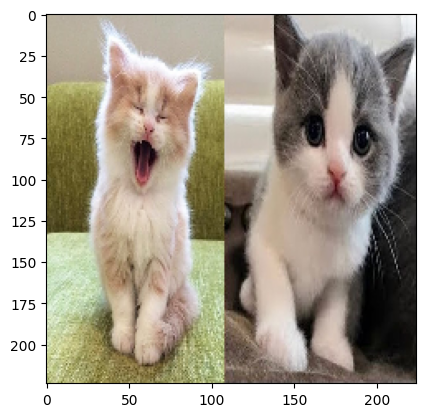

In [124]:
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

In [125]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

C:\Users\aplle\AppData\Local\Temp\ipykernel_25704\163353590.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1731191988531, current_stage='Production', description='', last_updated_timestamp=1731192119077, name='cat_dog_classifier', run_id='3b17533c20d744c88f1df353c84d56af', run_link='', source='mlflow-artifacts:/412419221304818620/3b17533c20d744c88f1df353c84d56af/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

C:\Users\aplle\OneDrive\Documentos\2024-2\ArquitecturaDeSoftware\ml-flow-env\mlflow_env\Lib\site-packages\mlflow\store\artifact\utils\models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
This image is 95.78% cat and 4.22% dog.


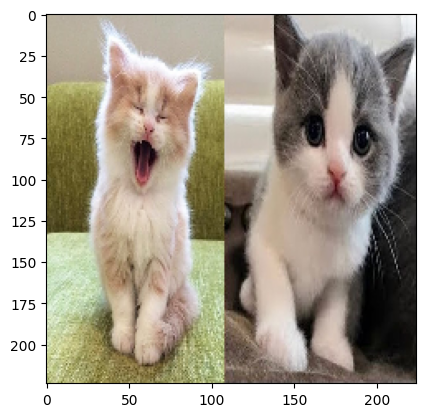

In [126]:
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/production"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

In [129]:
endpoint = "http://localhost:7777/invocations"

This image is 95.78% cat and 4.22% dog.


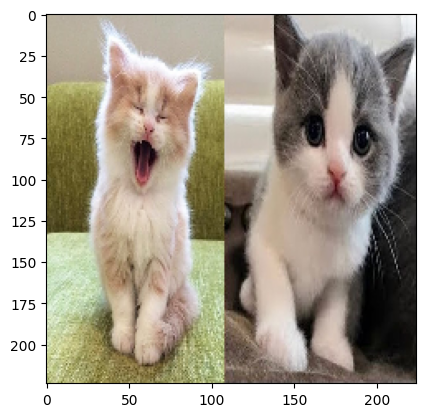

In [130]:
image_request = {
        "instances":img_array.numpy().tolist()
}

response = requests.post(endpoint, json=image_request)

predictions = eval(response.text)["predictions"]
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))